In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats
import sklearn

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [3]:
flat_samples_exp=np.loadtxt("chain_EXP_PCA.txt")

In [4]:
parameters=["Om","Ol","M","deltaM","a","b","sig"]
fit_results_exp={}
for i in range(7):
    percentile=np.percentile(flat_samples_exp[:,i],[16,50,84])
    fit_results_exp[parameters[i]]=[percentile[1],np.diff(percentile)[0],np.diff(percentile)[1]]

In [5]:
flat_samples_salt2=np.loadtxt("chain_SALT2_PCA_subsample.txt")

In [6]:
parameters=["Om","Ol","M","deltaM","a","b","sig"]
fit_results_salt2={}
for i in range(7):
    percentile=np.percentile(flat_samples_salt2[:,i],[16,50,84])
    fit_results_salt2[parameters[i]]=[percentile[1],np.diff(percentile)[0],np.diff(percentile)[1]]

In [7]:
labels_gdist = [r"\Omega_{m0}",r"\Omega_{\Lambda 0}",r"\mathcal{M}",r"\Delta_M",r"\alpha",r"\beta",r"\sigma_{int}"]
names_gdist = ["Om","Ol","M","deltaM","a","b","sig"]

In [8]:
samples_exp = MCSamples(samples=flat_samples_exp, names=names_gdist, labels=labels_gdist, label="EXP PCA")

Removed no burn in


In [9]:
samples_salt2 = MCSamples(samples=flat_samples_salt2, names=names_gdist, labels=labels_gdist, label="SALT2")

Removed no burn in


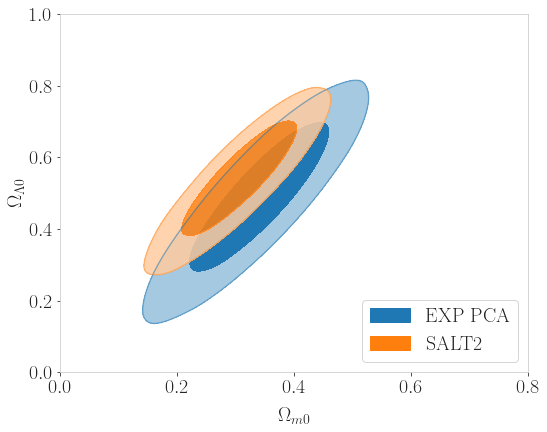

In [10]:
g = plots.get_single_plotter(width_inch=8, ratio=4 / 5.)
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.plot_2d([samples_exp, samples_salt2], ['Om', 'Ol'], filled=True, colors=["C0","C1"],lims=[0., 0.8,0., 1.]);
g.add_legend(["EXP PCA","SALT2"], legend_loc=4);
plt.savefig('./OM_OL_plane_comparison_PCA.pdf')  

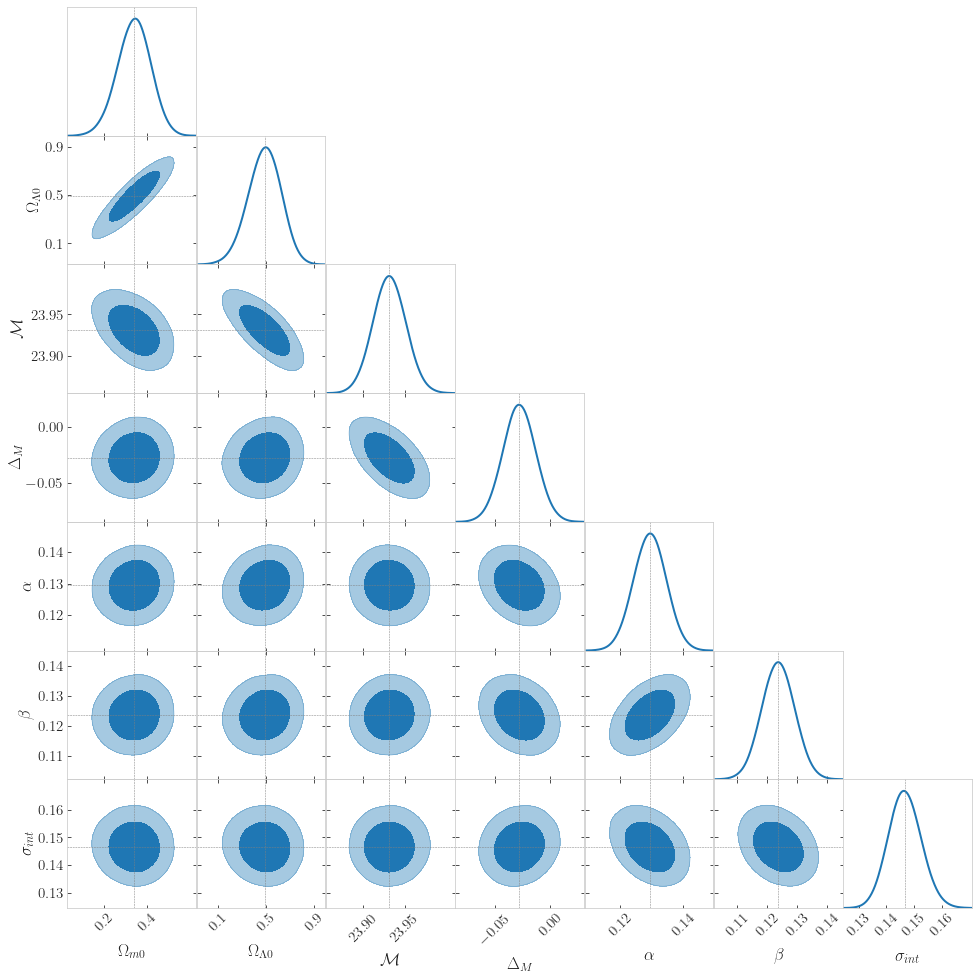

In [11]:
g = plots.get_subplot_plotter()
g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
g.triangle_plot([samples_exp], filled=True, line_args=[{'lw':2., 'color':"C0"}], contour_colors=["C0"], markers={'Om':fit_results_exp["Om"][0],'Ol':fit_results_exp["Ol"][0],'M':fit_results_exp["M"][0],'deltaM':fit_results_exp["deltaM"][0],'a':fit_results_exp["a"][0],'b':fit_results_exp["b"][0],'sig':fit_results_exp["sig"][0]}, marker_args={'lw':0.5})
plt.savefig('./cosmology_results_EXP_PCA.pdf')  

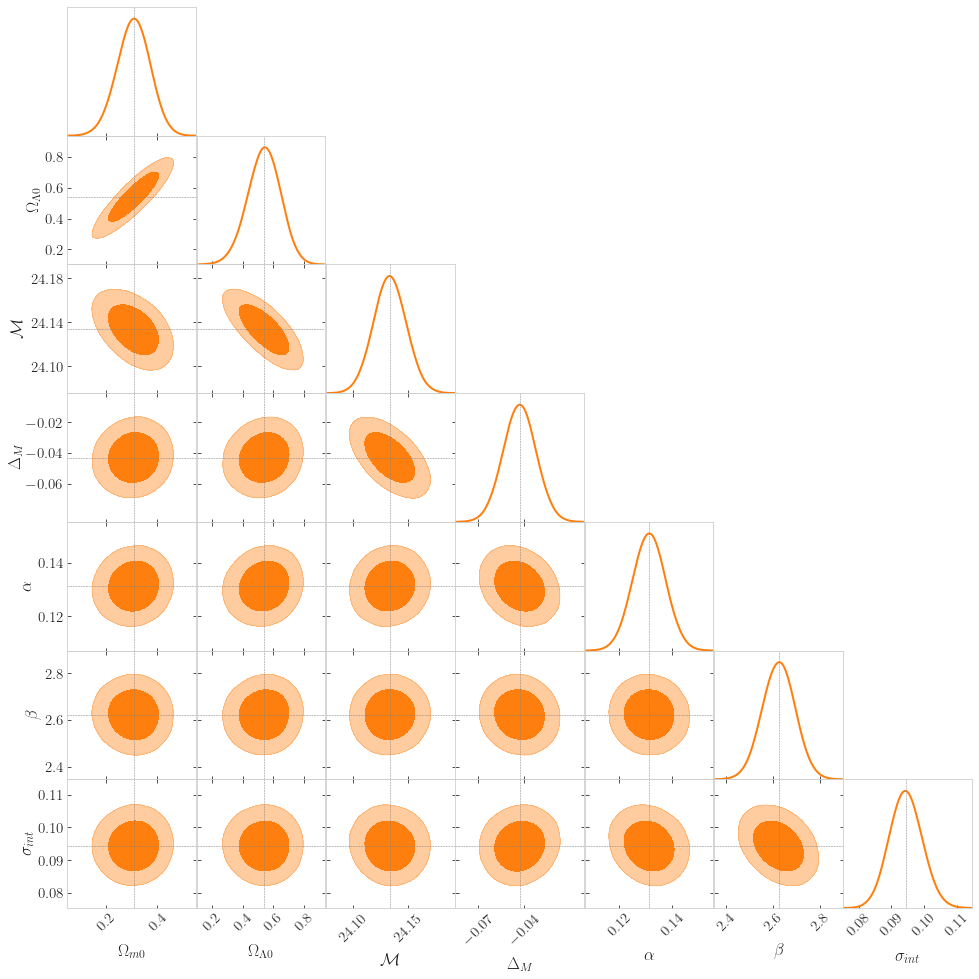

In [12]:
g = plots.get_subplot_plotter()
g.settings.axes_fontsize=18
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
g.triangle_plot([samples_salt2], filled=True, line_args=[{'lw':2., 'color':"C1"}], contour_colors=["C1"], markers={'Om':fit_results_salt2["Om"][0],'Ol':fit_results_salt2["Ol"][0],'M':fit_results_salt2["M"][0],'deltaM':fit_results_salt2["deltaM"][0],'a':fit_results_salt2["a"][0],'b':fit_results_salt2["b"][0],'sig':fit_results_salt2["sig"][0]}, marker_args={'lw':0.5})
plt.savefig('./cosmology_results_SALT2_PCA_subsample.pdf')

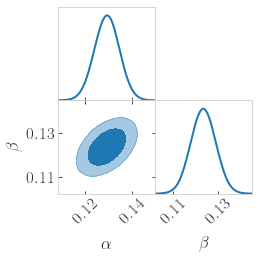

In [13]:
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot(samples_exp,params=['a', 'b'], filled=True,line_args={'lw':2., 'color':'C0'}, contour_colors=["C0"])
plt.savefig('./alpha_beta_triangle_plot_EXP_PCA.pdf')  

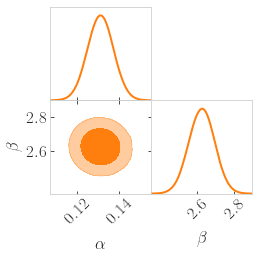

In [14]:
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot(samples_salt2,params=['a', 'b'], filled=True,line_args={'lw':2., 'color':'C1'}, contour_colors=["C1"])
plt.savefig('./alpha_beta_triangle_plot_SALT2_PCA_subsample.pdf')  

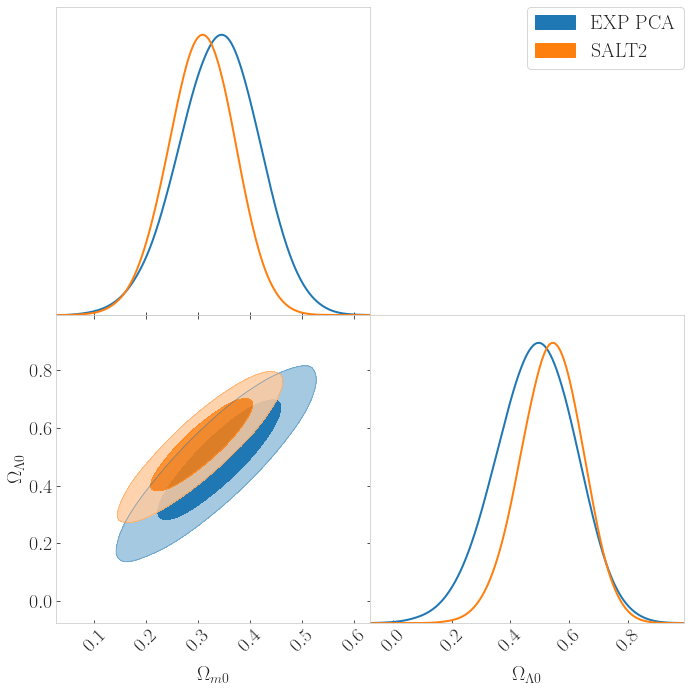

In [15]:
g = plots.get_subplot_plotter(subplot_size=5)
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.axis_tick_max_labels=10
g.settings.axis_tick_x_rotation=45
g.settings.legend_fontsize=20
g.triangle_plot([samples_exp, samples_salt2], ['Om', 'Ol'], filled=True,line_args=[{'lw':2., 'color':'C0'},{'lw':2, 'color':'C1'}], contour_colors=["C0","C1"])
plt.savefig('./OM_OL_triangle_plot_comparison_PCA.pdf')  

## Hubble Diagram

In [16]:
def mu(Om,Ol,M,red):
    Ok=1.-Om-Ol 
    h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
    integral=gk.integrate(h_inv,[np.array([0.]*len(red)),np.array(red)])
        
    if Ok==0:
        model=5*np.log10((1+red)*integral)+M
    elif Ok>0:
        model=5*np.log10((1+red)/np.sqrt(Ok)*np.sinh(np.sqrt(Ok)*integral))+M
    elif Ok<0:
        model=5*np.log10((1+red)/np.sqrt(-Ok)*np.sin(np.sqrt(-Ok)*integral))+M
    
    return model

In [17]:
fit_results_exp

{'Om': [0.3408313754178438, 0.07988788554471576, 0.07664489780828954],
 'Ol': [0.488738787604817, 0.14138595876828525, 0.13351449162779644],
 'M': [23.931593882291786, 0.019650212390271093, 0.019895318056537548],
 'deltaM': [-0.027813006814198474, 0.01476275070268055, 0.014852948507303471],
 'a': [0.12943006390615508, 0.0052354937369607085, 0.00518970283901074],
 'b': [0.12357915336726323, 0.005451488588937806, 0.005470203216198746],
 'sig': [0.14659635315000624, 0.005795123363075277, 0.0060371370472667996]}

In [18]:
fit_results_salt2

{'Om': [0.3070959169737927, 0.06537496623104316, 0.06346993008325069],
 'Ol': [0.5408508460666651, 0.10844233340513265, 0.10447478288444856],
 'M': [24.13356996597241, 0.014750410644683853, 0.014955697948821012],
 'deltaM': [-0.04305088795117582, 0.010673192989123219, 0.010663282654919781],
 'a': [0.13131278346447828, 0.006176600409316391, 0.00617022374151302],
 'b': [2.6235993688368158, 0.07050644757643587, 0.06930810854352254],
 'sig': [0.09441367850814734, 0.004955157491664211, 0.005075493504465678]}

In [19]:
Om=fit_results_exp["Om"][0]
Ol=fit_results_exp["Ol"][0]
M=fit_results_exp["M"][0]
deltaM=fit_results_exp["deltaM"][0]
alpha=fit_results_exp["a"][0]
beta=fit_results_exp["b"][0]
sigma=fit_results_exp["sig"][0]

In [20]:
data_exp=pd.read_csv("exp_PCA_fits_table.txt")

In [21]:
len(data_exp)

684

In [22]:
data_exp=data_exp.sort_values("z").reset_index(drop=True)

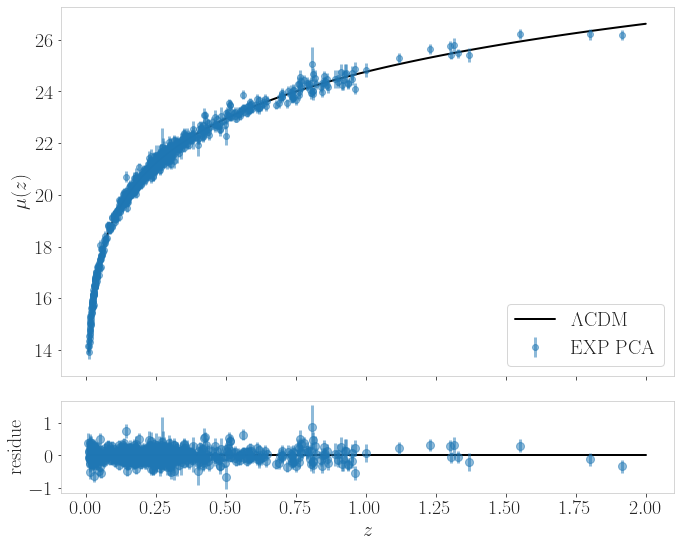

In [23]:
fig, ax=plt.subplots(2,1,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [4, 1]})

mu_exp=data_exp["mB"]-2.5*np.log10(1-alpha*data_exp["x1"]+beta*data_exp["x2"])-data_exp["is_log_mass_g_10"]*deltaM 
fator=-2.5/(np.log(10.)*(1-alpha*data_exp["x1"]+beta*data_exp["x2"]))

sigmaz=0.0012*(5/np.log(10.))*(1.+data_exp["z"])/(data_exp["z"]*(1.+data_exp["z"]/2.))
cov=-2.*alpha*fator*data_exp["cov_mB_x1"]+2*beta*fator*data_exp["cov_mB_x2"]-2*alpha*beta*fator**2*data_exp["cov_x1_x2"]
muerr_exp=sigma**2+sigmaz**2+data_exp["mBerr"]**2+alpha**2*fator**2*data_exp["x1err"]**2+beta**2*fator**2*data_exp["x2err"]**2+cov

ax[0].errorbar(data_exp["z"],mu_exp, yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=6,color="C0",zorder=1,mec = 'C0', mfc = 'C0',elinewidth=3,label="EXP PCA",alpha=0.5)
ax[0].plot(np.linspace(0.01,2.,100),mu(Om,Ol,M,red=np.linspace(0.01,2.,100)),color="black",label=r"$\Lambda$CDM",lw=2,zorder=0)
ax[0].set_ylabel(r"$\mu(z)$")
ax[0].legend(loc=4)

ax[1].errorbar(data_exp["z"],mu_exp-mu(Om,Ol,M,red=data_exp["z"]),yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=8,color="C0",zorder=1,mec = 'C0', mfc = 'C0',elinewidth=3,alpha=0.5)
ax[1].plot(np.linspace(0.01,2.,100),[0]*100,color="black",lw=2,zorder=0)
ax[1].set_ylabel("residue")
ax[1].set_xlabel(r"$z$")

fig.tight_layout()
plt.savefig('./HD_EXP_PCA.pdf',dpi=300);

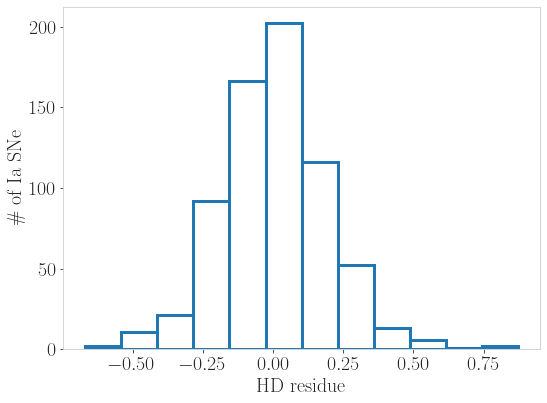

In [24]:
fig, ax=plt.subplots(figsize=(8,6))
                     
plt.hist(mu_exp-mu(Om,Ol,M,red=data_exp["z"]),bins=12,edgecolor="C0",fill=False,lw=3)
plt.ylabel("\# of Ia SNe")
plt.xlabel("HD residue")
plt.tight_layout()
plt.savefig('./HD_hist_residue_EXP_PCA.pdf',dpi=300);

In [25]:
np.mean(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))

0.006552958365641018

In [26]:
np.std(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))

0.1888983985281929

In [27]:
res=mu_exp-mu(Om,Ol,M,red=data_exp["z"])
print(stats.skew(res))
print(stats.skew(res[res<0.5]))

0.21747773327120493
-0.18673386795392138


In [28]:
np.std(res[res<0.5])

0.17637353389973331

In [29]:
df_residue=pd.DataFrame(mu_exp-mu(Om,Ol,M,red=data_exp["z"]))
df_mu_err=pd.DataFrame(muerr_exp)
df_w_res=pd.concat((df_residue,df_mu_err),axis=1)
df_w_res.columns=["residue","mu_err_exp"]

In [30]:
data_exp_w_res=pd.concat((data_exp,df_w_res),axis=1)

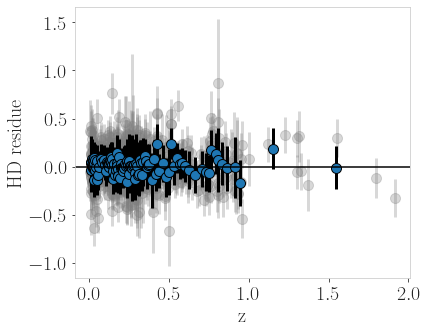

In [31]:
fig=plt.figure(figsize=(6,5))

data_z_sorted=data_exp_w_res.sort_values("z").reset_index(drop=True)
bins_z=[]
bins_res=[]
bins_err_res=[]
i=0
while i <len(data_z_sorted):
    bins_z.append(np.mean(data_z_sorted["z"][i:i+6]))
    bins_res.append(np.mean(data_z_sorted["residue"][i:i+6]))
    bins_err_res.append(np.mean(data_z_sorted["mu_err_exp"][i:i+6]))
    i+=6

plt.errorbar(data_z_sorted["z"],data_z_sorted["residue"],yerr=np.sqrt(data_z_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
plt.errorbar(bins_z,bins_res,yerr=np.sqrt(bins_err_res),marker='o',ls='none',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C0',elinewidth=3)
#plt.plot(bins_z,bins_res,marker='o',ls='none',markersize=3,color="black",zorder=1)
plt.axhline(y = 0., color = 'black', linestyle = '-')
#plt.errorbar(data_exp["z"],mu_exp-mu(Om,Ol,M,red=data_exp["z"]),yerr=np.sqrt(muerr_exp),ls="none",marker='o',markersize=3,color="#35b779")
plt.xlabel("z")
plt.ylabel("HD residue");

In [32]:
data_mB_sorted=data_exp_w_res.sort_values("mB").reset_index(drop=True)
bins_mB=[]
bins_res2=[]
bins_err_res2=[]
i=0
while i <len(data_z_sorted):
    bins_mB.append(np.mean(data_mB_sorted["mB"][i:i+6]))
    bins_res2.append(np.mean(data_mB_sorted["residue"][i:i+6]))
    bins_err_res2.append(np.mean(data_mB_sorted["mu_err_exp"][i:i+6]))
    i+=6

In [33]:
data_x1_sorted=data_exp_w_res.sort_values("x1").reset_index(drop=True)
bins_x1=[]
bins_res3=[]
bins_err_res3=[]
i=0
while i <len(data_z_sorted):
    bins_x1.append(np.mean(data_x1_sorted["x1"][i:i+10]))
    bins_res3.append(np.mean(data_x1_sorted["residue"][i:i+10]))
    bins_err_res3.append(np.mean(data_x1_sorted["mu_err_exp"][i:i+10]))
    i+=10

In [34]:
data_x2_sorted=data_exp_w_res.sort_values("x2").reset_index(drop=True)
bins_x2=[]
bins_res4=[]
bins_err_res4=[]
i=0
while i <len(data_x2_sorted):
    bins_x2.append(np.mean(data_x2_sorted["x2"][i:i+10]))
    bins_res4.append(np.mean(data_x2_sorted["residue"][i:i+10]))
    bins_err_res4.append(np.mean(data_x2_sorted["mu_err_exp"][i:i+10]))
    i+=10

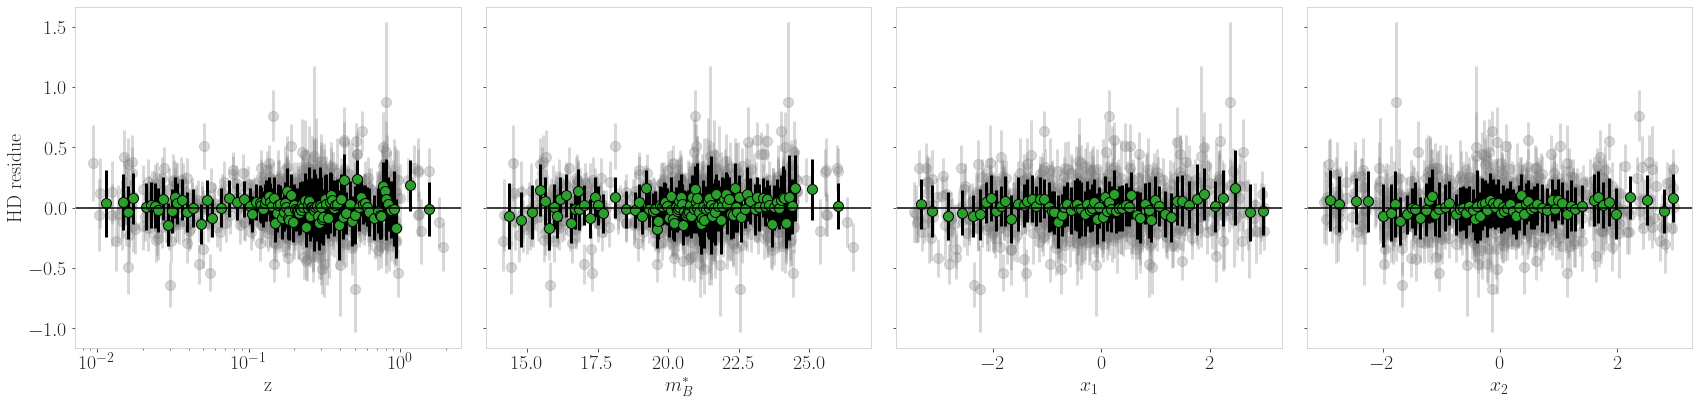

In [35]:
fig, axs=plt.subplots(1,4,figsize=(24,6),sharey=True)

axs[0].errorbar(data_z_sorted["z"],data_z_sorted["residue"],yerr=np.sqrt(data_z_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[0].errorbar(bins_z,bins_res,yerr=np.sqrt(bins_err_res),marker='o',ls='none',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[0].axhline(y = 0., color = 'black', linestyle = '-')
axs[0].set_xlabel("z")
axs[0].set_xscale('log')
axs[0].set_ylabel("HD residue")

axs[1].errorbar(data_mB_sorted["mB"],data_mB_sorted["residue"],yerr=np.sqrt(data_mB_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[1].errorbar(bins_mB,bins_res2,yerr=np.sqrt(bins_err_res2),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[1].axhline(y = 0., color = 'black', linestyle = '-')
axs[1].set_xlabel(r"$m_B^*$")

axs[2].errorbar(data_x1_sorted["x1"],data_x1_sorted["residue"],yerr=np.sqrt(data_x1_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[2].errorbar(bins_x1,bins_res3,yerr=np.sqrt(bins_err_res3),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[2].axhline(y = 0., color = 'black', linestyle = '-')
axs[2].set_xlabel(r"$x_1$")

axs[3].errorbar(data_x2_sorted["x2"],data_x2_sorted["residue"],yerr=np.sqrt(data_x2_sorted["mu_err_exp"]),ls="none",marker='o',markersize=10,color="C7",zorder=0,elinewidth=3,alpha=0.3)
axs[3].errorbar(bins_x2,bins_res4,yerr=np.sqrt(bins_err_res4),ls="none",marker='o',markersize=10,color="black",zorder=1,mec = 'black', mfc = 'C2',elinewidth=3)
axs[3].axhline(y = 0., color = 'black', linestyle = '-')
axs[3].set_xlabel(r"$x_2$")

plt.tight_layout()
plt.savefig('./HD_residue_dependences_PCA.pdf',dpi=300);

#### Comparisons with Host galaxy mass

In [36]:
reduced_data=data_exp_w_res[(data_exp_w_res["log_hm"]>=8.) & (data_exp_w_res["log_hm"]<=12.)]
data_log_hm_sorted=reduced_data.sort_values("log_hm").reset_index(drop=True)
bins_x1=[]
bins_x2=[]
bins_loghm=[]
bins_res=[]
i=0
while i <len(reduced_data):
    bins_x1.append(np.mean(data_log_hm_sorted["x1"][i:i+25]))
    bins_x2.append(np.mean(data_log_hm_sorted["x2"][i:i+25]))
    bins_loghm.append(np.mean(data_log_hm_sorted["log_hm"][i:i+25]))
    bins_res.append(np.mean(data_log_hm_sorted["residue"][i:i+25]))
    i+=25

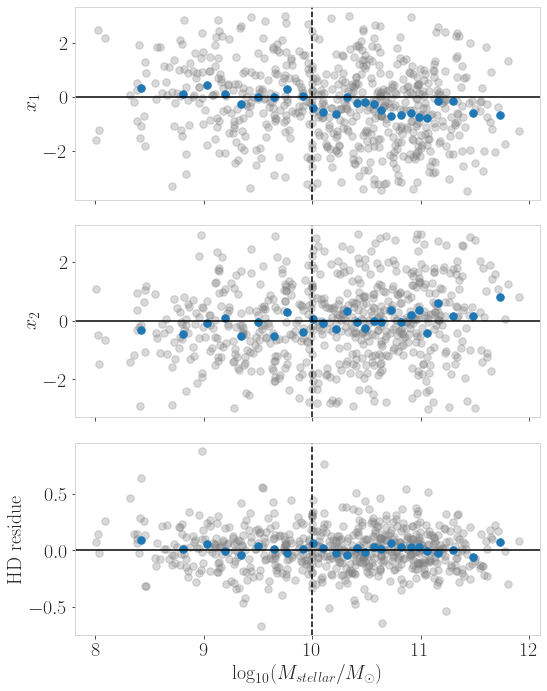

In [37]:
fig, axs=plt.subplots(3,1,figsize=(8,10),sharex=True)

axs[0].plot(reduced_data["log_hm"],reduced_data["x1"],'.',markersize=15,c="C7",alpha=0.3)
axs[0].plot(bins_loghm,bins_x1,".",markersize=15)
axs[0].axhline(0.,c="k")
axs[0].axvline(10.,ls="--",c="k")
axs[0].set_ylabel(r"$x_1$")

axs[1].plot(reduced_data["log_hm"],reduced_data["x2"],'.',markersize=15,c="C7",alpha=0.3)
axs[1].plot(bins_loghm,bins_x2,".",markersize=15)
axs[1].axhline(0.,c="k")
axs[1].axvline(10.,ls="--",c="k")
axs[1].set_ylabel(r"$x_2$")

axs[2].plot(reduced_data["log_hm"],reduced_data["residue"],'.',markersize=15,c="C7",alpha=0.3)
axs[2].plot(bins_loghm,bins_res,".",markersize=15)
axs[2].axhline(0.,c="k")
axs[2].axvline(10.,ls="--",c="k")
axs[2].set_xlabel(r"$\log_{10}(M_{stellar}/M_{\odot})$")
axs[2].set_ylabel("HD residue")

plt.tight_layout()
plt.savefig('./parameters_dep_w_host_mass_PCA.pdf',dpi=300);

## Distance modulus differences scatter plot

In [38]:
Om_salt2=fit_results_salt2["Om"][0]
Ol_salt2=fit_results_salt2["Ol"][0]
M_salt2=fit_results_salt2["M"][0]
deltaM_salt2=fit_results_salt2["deltaM"][0]
alpha_salt2=fit_results_salt2["a"][0]
beta_salt2=fit_results_salt2["b"][0]
sigma_salt2=fit_results_salt2["sig"][0]

In [39]:
data_salt2=pd.read_csv("SALT2_PCA_subsample_fits_table.txt")

In [40]:
data_salt2=data_salt2.sort_values("z").reset_index(drop=True)

In [41]:
mu_salt2=data_salt2["mB"]+alpha_salt2*data_salt2["x1"]-beta_salt2*data_salt2["x2"]-data_salt2["is_log_mass_g_10"]*deltaM_salt2

sigmaz=0.0012*(5/np.log(10.))*(1.+data_salt2["z"])/(data_salt2["z"]*(1.+data_salt2["z"]/2.))

cov=2.*alpha_salt2*data_salt2["cov_mB_x1"]+2*beta_salt2*data_salt2["cov_mB_x2"]-2*alpha_salt2*beta_salt2*data_salt2["cov_x1_x2"]
muerr_salt2=sigma_salt2**2+sigmaz**2+data_salt2["mBerr"]**2+alpha_salt2**2*data_salt2["x1err"]**2+beta_salt2**2*data_salt2["x2err"]**2+cov

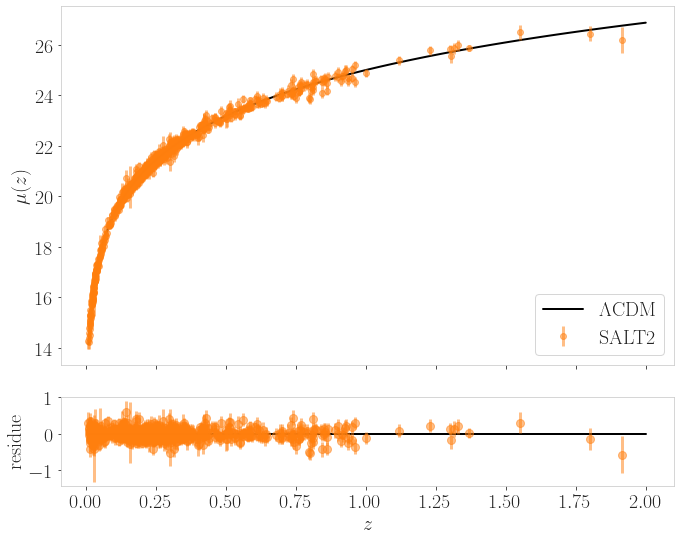

In [42]:
fig, ax=plt.subplots(2,1,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [4, 1]})

ax[0].errorbar(data_salt2["z"],mu_salt2, yerr=np.sqrt(muerr_salt2),ls="none",marker='o',markersize=6,color="C1",zorder=1,mec = 'C1', mfc = 'C1',elinewidth=3,label="SALT2",alpha=0.5)
ax[0].plot(np.linspace(0.01,2.,100),mu(Om_salt2,Ol_salt2,M_salt2,red=np.linspace(0.01,2.,100)),color="black",label=r"$\Lambda$CDM",lw=2,zorder=0)
ax[0].set_ylabel(r"$\mu(z)$")
ax[0].legend(loc=4)

ax[1].errorbar(data_salt2["z"],mu_salt2-mu(Om_salt2,Ol_salt2,M_salt2,red=data_salt2["z"]),yerr=np.sqrt(muerr_salt2),ls="none",marker='o',markersize=8,color="C1",zorder=1,mec = 'C1', mfc = 'C1',elinewidth=3,alpha=0.5)
ax[1].plot(np.linspace(0.01,2.,100),[0]*100,color="black",lw=2,zorder=0)
ax[1].set_ylabel("residue")
ax[1].set_xlabel(r"$z$")

fig.tight_layout();

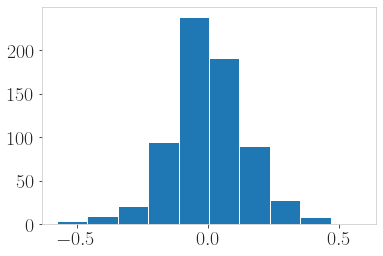

In [44]:
hd_res_salt2=mu_salt2-mu(Om_salt2,Ol_salt2,M_salt2,red=data_salt2["z"])
plt.hist(hd_res_salt2);

In [45]:
np.mean(hd_res_salt2)

-0.0013498824855474984

In [46]:
np.std(hd_res_salt2)

0.14653830946036317

In [42]:
len(data_salt2)

684

In [43]:
bins_z_comp=[]
bins_dif_comp=[]
mu_dif=mu_salt2-mu_exp
mu_dif_per_bin=[]
std=[]
i=0
while i<len(data_salt2):
    bins_z_comp.append(np.mean(data_salt2["z"][i:i+20]))
    bins_dif_comp.append(np.mean(mu_dif[i:i+20]))
    std.append(np.std(mu_dif[i:i+20]))
    mu_dif_per_bin.append(mu_dif[i:i+20])
    i+=20

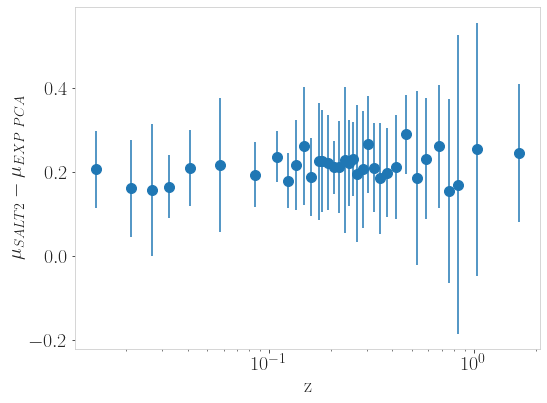

In [44]:
fig=plt.figure(figsize=(8,6))

#plt.plot(data_salt2["z"],mu_salt2-mu_exp,'.',markersize=15,alpha=0.6,c="C7")
plt.errorbar(bins_z_comp,bins_dif_comp,yerr=std,marker='o',markersize=10,c="C0",ls="none")
#plt.ylim(7.9,8.7) # THE GRAPH LIMIT IS REDUCED TO IMPROVE VISUALIZATION, THE LOWEST POINT SHOWS THE BEHAVIOUR OF OMITTED ONES
plt.xlabel("z")
plt.ylabel(r"$\mu_{SALT2}-\mu_{EXP\,\, PCA}$")
plt.xscale("log")
plt.tight_layout()
plt.savefig('./distance_mod_dif_evol_w_z_PCA.pdf',dpi=300);

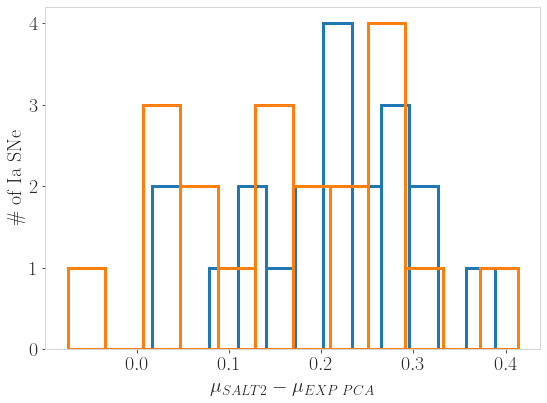

In [45]:
fig=plt.figure(figsize=(8,6))
                     
plt.hist(mu_dif_per_bin[0],bins=12,edgecolor="C0",fill=False,lw=3)
plt.hist(mu_dif_per_bin[1],bins=12,edgecolor="C1",fill=False,lw=3)
plt.ylabel("\# of Ia SNe")
plt.xlabel("$\mu_{SALT2}-\mu_{EXP\,\, PCA}$")
plt.tight_layout()

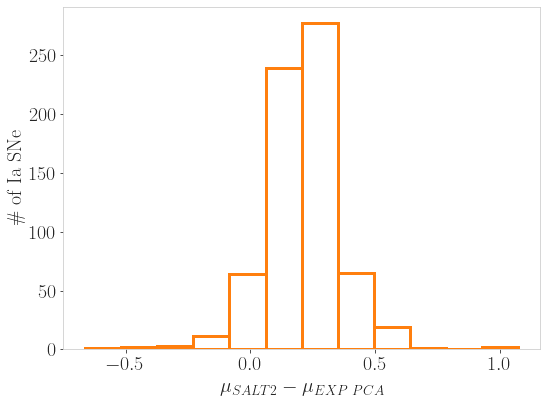

In [46]:
fig=plt.figure(figsize=(8,6))
                     
plt.hist(mu_salt2-mu_exp,bins=12,edgecolor="C1",fill=False,lw=3)
plt.ylabel("\# of Ia SNe")
plt.xlabel("$\mu_{SALT2}-\mu_{EXP\,\, PCA}$")
plt.tight_layout()
plt.savefig('./distance_mod_dif_PCA.pdf',dpi=300);

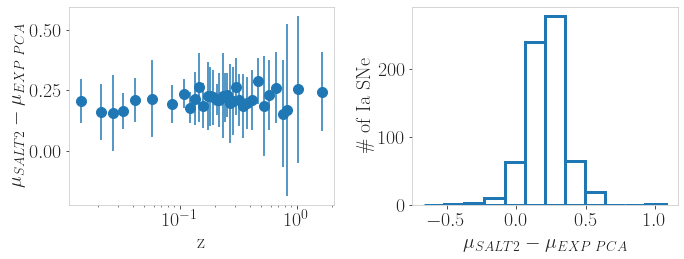

In [47]:
fig,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].errorbar(bins_z_comp,bins_dif_comp,yerr=std,c="C0",marker='o',markersize=10,ls="none")
axs[0].set_xlabel("z")
axs[0].set_ylabel(r"$\mu_{SALT2}-\mu_{EXP\,\, PCA}$")
axs[0].set_xscale("log")

axs[1].hist(mu_salt2-mu_exp,bins=12,edgecolor="C0",fill=False,lw=3)
axs[1].set_ylabel("\# of Ia SNe")
axs[1].set_xlabel("$\mu_{SALT2}-\mu_{EXP\,\, PCA}$")

fig.tight_layout()
plt.savefig('./distance_mod_dif_evol_w_z_hist_PCA.pdf',dpi=300);

In [48]:
np.mean(mu_salt2-mu_exp)

0.21133012406196308

In [49]:
np.std(mu_salt2-mu_exp)

0.14969116222287446

In [50]:
stats.skew(mu_salt2-mu_exp)

-0.07838025867090143

### Massa da galáxia hospedeira em função do survey

In [51]:
PS1_sn=['34', '142', '190', '199', '236', '420', '20027', '20096', '20176',
       '30066', '40782', '50293', '70955', '80723', '91869', '100213',
       '100405', '110033', '110478', '110536', '110719', '110734',
       '120085', '120094', '120336', '130308', '130514', '140181',
       '150509', '160039', '160099', '160200', '170428', '180166',
       '180561', '190230', '190260', '300105', '310073', '310161',
       '310238', '310574', '320258', '330022', '330089', '330128',
       '330146', '350047', '350083', '350233', '350548', '360112',
       '360140', '370098', '370428', '370563', '380378', '420159',
       '420407', '420417', '430004', '440008', '440042', '440162',
       '460003', '460037', '470008', '470041', '470232', '470244',
       '480064', '480464', '490008', '500057', '500100', '500504',
       '510251', '510457', '510578', '510638', '520062',
       '520077', '520188', '530112', '550041', '550096', '550154',
       '560121', '560152', '570062', '580235', '580275', '580300',
       '590005', '200132', '10', '38', '137', '174', '196', '202', '220',
       '10010', '20090', '30006', '40150', '40201', '40780', '50291',
       '50296', '80646', '90037', '90275', '100206', '110425', '110430',
       '110460', '110716', '120044', '120086', '120143', '120369',
       '120444', '130755', '140152', '150254', '150457', '160070',
       '160198', '170078', '190340', '300179', '310039', '310051',
       '310090', '310146', '310188', '310260', '320099', '330083',
       '340229', '350027', '350050', '350080', '350192', '350235',
       '350630', '360139', '360145', '370344', '370498', '370566',
       '370595', '390259', '390449', '420196', '420414', '440005',
       '450082', '460064', '470110', '490007', '500038', '500065',
       '500511', '510113', '510266', '510550', '510597', '520041',
       '520071', '530037', '530086', '550137', '550202', '560150',
       '570022', '570056', '580104', '580270', '590031',
       '380199']

In [52]:
SNLS_sn=['03D1ax', '03D3ay', '03D4ag', '03D4cz', '03D4di',
       '03D4fd', '03D4gg', '04D1ff', '04D1hx', '04D1jg', '04D1ks',
       '04D1ow', '04D1pd', '04D1pp', '04D1qd', '04D1si', '04D2cf',
       '04D2fs', '04D2kr', '04D3co', '04D3do', '04D3fk', '04D3hn',
       '04D3ks', '04D3lu', '04D3ml', '04D3nh', '04D3ny', '04D4an',
       '04D4bq', '04D4gg', '04D4jr', '05D1az', '05D1cc', '05D1em',
       '05D1er', '05D1ix', '05D1ke', '05D2ab', '05D2ah', '05D2bt',
       '05D2bw', '05D2cb', '05D2dt', '05D2dy', '05D2hc', '05D2mp',
       '05D3cf', '05D3cq', '05D3dd', '05D3gp', '05D3ha', '05D3jb',
       '05D3jk', '05D3jr', '05D3kp', '05D3kx', '05D3mn', '05D3mx',
       '05D4af', '05D4av', '05D4bf', '05D4bj', '05D4cn', '05D4cs',
       '05D4dt', '05D4dy', '05D4ej', '05D4ev', '05D4fg', '05D4gw',
       '06D2bk', '06D2cc', '06D2fb', '06D3ed', '06D3et', '06D4bo',
       '06D4co', '03D1bp', '03D1fc', '03D3cd', '03D4at', '03D4cy',
       '03D4dh', '03D4dy', '03D4gf', '04D1de', '04D1hy', '04D1jd',
       '04D1kj', '04D1oh', '04D1pc', '04D1pg', '04D1rh', '04D1sa',
       '04D2an', '04D2fp', '04D2gp', '04D2ja', '04D2mc', '04D2mj',
       '04D3cy', '04D3ez', '04D3gx', '04D3kr', '04D3mk', '04D3nc',
       '04D3nr', '04D4dm', '04D4in', '04D4jy', '05D1cb', '05D1dn',
       '05D1ee', '05D1hk', '05D1if', '05D1kl', '05D2ac', '05D2bv',
       '05D2dw', '05D2eb', '05D2le', '05D2nt', '05D3ci', '05D3cx',
       '05D3dh', '05D3hh', '05D3ht', '05D3jh', '05D3km', '05D3kt',
       '05D3la', '05D3lc', '05D3mq', '05D4ag', '05D4be', '05D4bm',
       '05D4cq', '05D4cw', '05D4ef', '05D4ff', '05D4fo', '05D4hn',
       '06D2ca', '06D2ck', '06D3df', '06D3dt', '06D3el', '06D3fp',
       '06D4bw', '06D4cl', '06D4cq']

In [53]:
SDSS_sn=['744', '1241', '1371', '1580',
       '1794', '2031', '2102', '2635', '2916', '2992', '3080', '3087',
       '3317', '3451', '4046', '5103', '5549', '5635', '5957', '5994',
       '6057', '6196', '6315', '6422', '6558', '6924', '7147', '7243',
       '7847', '8495', '8921', '9032', '9467', '12779', '12856', '12881',
       '12898', '12927', '12950', '12972', '13005', '13038', '13044',
       '13152', '13254', '13411', '13610', '13689', '13736', '13796',
       '14108', '14331', '14421', '14735', '14871', '14979', '15129',
       '15161', '15219', '15234', '15259', '15287', '15301',
       '15421', '15443', '15461', '15467', '15583', '15868', '15901',
       '16021', '16073', '16116', '16165', '16213', '16281', '17168',
       '17215', '17218', '17366', '17497', '17784', '17811', '17825',
       '17875', '17884', '18030', '18241', '18323', '18325', '18466',
       '18486', '18602', '18697', '18804', '18809', '18927', '18940',
       '18945', '19002', '19023', '19027', '19282', '19596', '19632',
       '19775', '19818', '19913', '19953', '19969', '19990', '20039',
       '20084', '20142', '20227', '21502', '722', '762', '774', '1032',
       '2017', '2246', '2308', '2372', '2533', '2561', '3199', '3452',
       '3592', '5391', '5395', '5550', '5717', '5736', '5751', '5844',
       '6137', '6192', '6249', '6304', '6406', '6649', '6933', '6936',
       '7473', '7512', '7876', '8046', '8719', '10028', '10434', '10805',
       '12843', '12853', '12855', '12860', '12928', '12977', '13025',
       '13045', '13070', '13135', '13305', '13354', '13641', '13655',
       '13894', '14157', '14261', '14284', '14298', '14437', '14846',
       '15132', '15171', '15203', '15222', '15425', '15433', '15453',
       '15466', '15508', '15648', '15872', '16069', '16100', '16276',
       '16350', '17186', '17208', '17253', '17280', '17332',
       '17340', '17435', '17605', '17629', '18415', '18463', '18485',
       '18612', '18650', '18740', '18787', '18807', '19008', '19101',
       '19543', '19616', '19658', '19702', '19757', '19940',
       '19992', '20064', '20144', '20345', '20625', '20764', '21034',
       '22075']

In [54]:
LOWZ_sn=['2001ah', '2001az', '2001da', '2001en', '2001fe',
       '2001G', '2001V', '2002bf', '2002ck', '2002cr', '2002de',
       '2002dp', '2002he', '2003ae', '2003cq', '2003fa', '2003it',
       '2004as', '2004ef', '2005hf', '2005hj', '2005lz', '2005ms',
       '2005na', '2006ac', '2006ah', '2006ak', '2006al', '2006ax',
       '2006bq', '2006cj', '2006cp', '2006cq', '2006en', '2006gr',
       '2006is', '2006mp', '2006oa', '2006on', '2006sr', '2006td',
       '2006te', '2007ae', '2007co', '2007cq', '2007F', '2007O', '2008af',
       '2008bf', '2007A', '2007aj', '2007cc', '2007hu', '2007is',
       '2007kh', '2007kk', '2007nq', '2007ob', '2007su', '2008C', '2008Y',
       '2008ac', '2008ar', '2008by', '2008bz', '2008cf', '2008ds',
       '2008fr', '2008gb', '2008gl', '2009D', '2009ad', '2009an',
       '2009ds', '2008050', '2008051', '2009kk', '2009kq', '2009na',
       '2009nq', '2010H', '2010dt', 'PTF10bjs', '2004eo', '2005eq',
       '2005hc', '2005iq', '2005lu', '2006ef', '2006et', '2006lu',
       '2006py', '2007bc', '2008bq', '2008hv', '1993ac', '1993ae',
       '1994M', '1994Q', '1994S', '1995ak', '1996bl', '1996C', '1997dg',
       '1997Y', '1998dx', '1998ec', '1998eg', '1999cc', '1999dq',
       '1999ef', '1999ej', '1999X', '2000cf', '2000fa']

In [55]:
HST_sn=['washington',
       'Primo', 'stone', 'wilson', 'Aphrodite', 'Frodo',
       'Gabi', 'Lancaster', 'Manipogo', 'Mcguire', 'Rakke', 'Thoth',
       'Vilas', 'SCP05D6']

In [56]:
PS1_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in PS1_sn]
SNLS_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in SNLS_sn]
SDSS_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in SDSS_sn]
LOWZ_log_hm=[data_exp[data_exp["sn"]==s]["log_hm"].values[0] for s in LOWZ_sn]

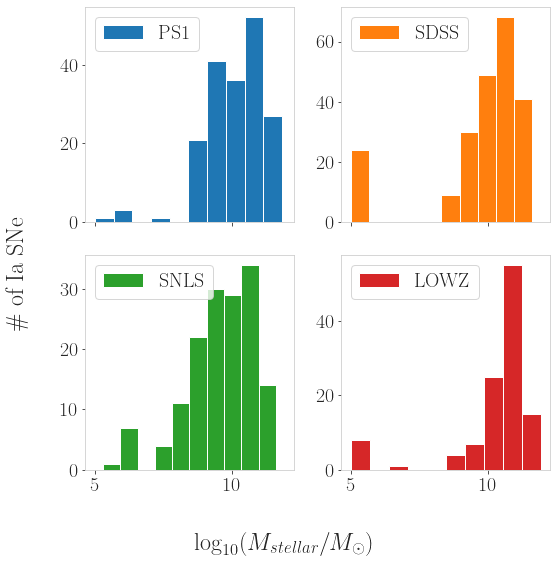

In [57]:
fig, axs=plt.subplots(2,2,figsize=(8,8),sharex=True)

axs[0,0].hist(PS1_log_hm,label="PS1",color="C0")
axs[0,0].legend()
axs[0,1].hist(SDSS_log_hm,label="SDSS",color="C1")
axs[0,1].legend()
axs[1,0].hist(SNLS_log_hm,label="SNLS",color="C2")
axs[1,0].legend()
axs[1,1].hist(LOWZ_log_hm,label="LOWZ",color="C3")
axs[1,1].legend()

fig.supxlabel(r"$\log_{10}(M_{stellar}/M_{\odot})$")
fig.supylabel(r"\# of Ia SNe")
fig.tight_layout()
plt.savefig('./distribution_hostmass_PCA.pdf');

## Calculando mB additive term